In [64]:
# tensorflow imports
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow_datasets as tfds

# machine learning libraries
import numpy as np
import matplotlib.pyplot as plt



In [65]:
dataset, dataset_info = tfds.load("malaria", with_info=True, as_supervised=True, shuffle_files=True, split=["train"])

In [66]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):

  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE)).take(int(VAL_RATIO*DATASET_SIZE))
  test_dataset = dataset.skip(int((TRAIN_RATIO+VAL_RATIO)*DATASET_SIZE)).take(int(TEST_RATIO*DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset




In [67]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

#dataset = tf.data.Dataset.range(10)

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)


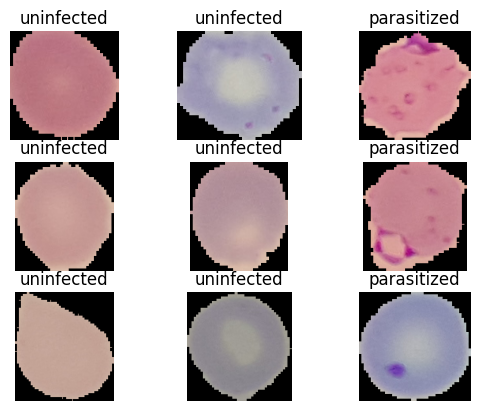

In [68]:
for i, (image, label) in enumerate(train_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')


In [69]:
IMG_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IMG_SIZE, IMG_SIZE))/255.0, label

In [70]:
BATCH_SIZE = 32
BUFFER_SIZE = 8
train_dataset = train_dataset.map(resize_rescale)
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(resize_rescale)
val_dataset = val_dataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(resize_rescale)

val_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [71]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(IMG_SIZE,IMG_SIZE,3)),

    Conv2D(filters=6, kernel_size=5, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=5, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(1000, activation="relu"),
    BatchNormalization(),

    Dense(100, activation="relu"),
    BatchNormalization(),

    Dense(1, activation="sigmoid")
])
model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 220, 220, 6)       456       
                                                                 
 batch_normalization_20 (Ba  (None, 220, 220, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 110, 110, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_21 (Ba  (None, 106, 106, 16)      64        
 tchNormalization)                                               
                                                      

In [72]:
# Learning rate scheduler
def lr_schedule(epoch):
    if epoch < 10:
        return 0.1
    if epoch >= 10 and epoch < 20:
        return 0.01
    return 0.001

lr_scheduler = LearningRateScheduler(lr_schedule)


In [73]:
model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss=BinaryCrossentropy(),
    metrics="accuracy"
  )
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,  # 10 epochs with lr=0.1 + 10 epochs with lr=0.01
    callbacks=[lr_scheduler],
    verbose=1
)

Epoch 1/25
689/689 [==============================] - 60s 82ms/step - loss: 0.6484 - accuracy: 0.6433 - val_loss: 14.4656 - val_accuracy: 0.5042 - lr: 0.1000
Epoch 2/25
689/689 [==============================] - 56s 81ms/step - loss: 0.3616 - accuracy: 0.8661 - val_loss: 2.3386 - val_accuracy: 0.4947 - lr: 0.1000
Epoch 3/25
689/689 [==============================] - 57s 83ms/step - loss: 0.3508 - accuracy: 0.8744 - val_loss: 2.4001 - val_accuracy: 0.6069 - lr: 0.1000
Epoch 4/25
689/689 [==============================] - 50s 72ms/step - loss: 0.2683 - accuracy: 0.9115 - val_loss: 0.2519 - val_accuracy: 0.9372 - lr: 0.1000
Epoch 5/25
689/689 [==============================] - 51s 74ms/step - loss: 0.2378 - accuracy: 0.9278 - val_loss: 0.4697 - val_accuracy: 0.9020 - lr: 0.1000
Epoch 6/25
689/689 [==============================] - 51s 73ms/step - loss: 0.1997 - accuracy: 0.9399 - val_loss: 0.2339 - val_accuracy: 0.9278 - lr: 0.1000
Epoch 7/25
689/689 [==============================] - 49s

In [74]:
test_dataset = test_dataset.batch(1)
model.evaluate(test_dataset)

2755/2755 [==============================] - 24s 4ms/step - loss: 0.2674 - accuracy: 0.9426


[0.267356812953949, 0.9426497220993042]

In [75]:
def parasite_or_not(x) -> str:
  if x < 0.5:
    return str("P")
  return str("U")
parasite_or_not(model.predict(test_dataset.take(1))[0][0])


1/1 [==============================] - 12s 12s/step


'U'

1/1 [==============================] - 0s 20ms/step


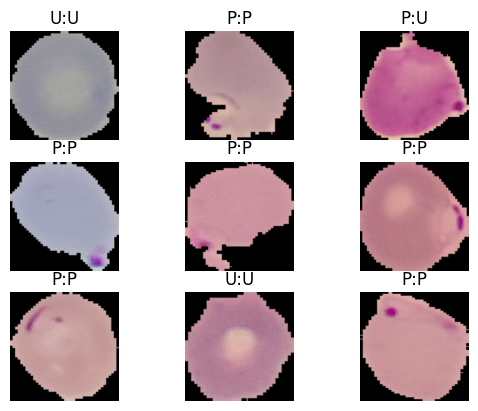

In [76]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis("off")
